* **importatation des bibliothèques**

In [13]:
import random
import matplotlib.pyplot as plt
import pandas as pd
from display import Displayable # displayable est une classe dans le fichier display.py

* **Définir la classe Agent**

In [2]:
class Agent:
  def __init__(self,env):
    """ configurer un agent """
    self.env=env # env signifie l'environnement avec lequel l'agent va intéragir
    
  def go(self,n):
    """l'agent va intéragir avec l'environnement n fois"""
    raise NotImplementedError("go")   # abstract method

* **Définir la classe Environment** 

In [4]:
class Environment(Displayable): # La classe Environment est une sous classe de Displayable
  def initial_percepts(self):
    """retourner la perception initiale à l'agent"""
    raise NotImplementedError("initial_percepts")   # abstract method
    
  def do(self,action):
    """exécuter l'action de l'agent sur l'environnement et retourner la perception suivante"""
    raise NotImplementedError("do")   # abstract method

* **Définir la classe TP_env (sous classe de Environment)**

In [5]:
class TP_env(Environment):

  # prices: liste contenant les prix initiaux du papier à des instants différents (taille = 78)
  prices = [234, 234, 234, 234, 255, 255, 275, 275, 211, 211, 211, 234, 234,
            234, 234, 199, 199, 275, 275, 234, 234, 234, 234, 255, 255, 260,
            260, 265, 265, 265, 265, 270, 270, 255, 255, 260, 260, 265, 265,
            150, 150, 265, 265, 270, 270, 255, 255, 260, 260, 265, 265, 265,
            265, 270, 270, 211, 211, 255, 255, 260, 260, 265, 265, 260, 265,
            270, 270, 205, 255, 255, 260, 260, 265, 265, 265, 265, 270, 270]

  max_price_addon = 20  # la valeur maximale à ajouter au prix initial du papier [0 .. 20]

  def __init__(self):
    """Définir les attributs de l'environnement"""
    self.time=0
    self.stock=20
    self.stock_history = []  # mémoriser l'historique du stock
    self.price_history = []  # mémoriser l'historique des prix du papier
    self.used_history = [] # mémoriser l'historique des papiers utilisés

  def initial_percepts(self):
    """retourner la perception initiale à l'agent"""
    # La perception retournée à l'agent contient le prix et la quantité en stock du papier
    self.stock_history.append(self.stock)
    price = self.prices[0]+random.randrange(self.max_price_addon)
    self.price_history.append(price)
    return {'price': price, 'instock': self.stock}

  def do(self, action):
    """exécuter l'action de l'agent (achat papier) et retourner la nouvelle perception (prix et stock)"""
    used = self.pick_from_dist({6:0.1, 5:0.1, 4:0.2, 3:0.3, 2:0.2, 1:0.1}) # retirer une quantité du stock
    bought = action['buy'] # acheter une quantité de papiers
    self.stock = self.stock + bought - used
    self.stock_history.append(self.stock)
    self.time += 1
    price = (self.prices[self.time%len(self.prices)] # repeating pattern
             + random.randrange(self.max_price_addon) # plus randomness (0..20)
             + self.time//2)                          # plus inflation
    self.price_history.append(price)
    self.used_history.append(used)
    return {'price': price, 'instock': self.stock}

  def pick_from_dist(self, item_prob_dist):
    """ retourner une valeur de la distribution.
    item_prob_dist est un dictionnaire de la forme item:probability, avec la 
        somme des probabilitées est égale à 1.
    """
    ranreal = random.random() # compris entre 0 et 1
    for (it,prob) in item_prob_dist.items():
        if ranreal < prob:
            return it
        else:
            ranreal -= prob
    raise RuntimeError(str(item_prob_dist)+" is not a probability distribution")

* **Définir la classe TP_agent (sous classe de Agent)**

In [6]:
class TP_agent(Agent):
  def __init__(self, env):
    """Définir les attributs de l'agent
    """
    self.env = env  # env est l'environnement avec lequel l'agent va intéragir
    self.spent = 0 # l'agent n'a rien dépensé pour l'instant  
    percepts = env.initial_percepts() # percepts est un dictionnaire contenant l'état initial de env (prix, stock)
    self.ave = self.last_price = percepts['price'] # ave est la moyenne des prix du papier durant les intéractions  
    self.instock = percepts['instock'] # quantité du papier en stock
    self.buy_history = []

        
  def go(self, n):
    """intéragir avec l'environement n fois
    """
    for i in range(n):
      if self.last_price < (0.9 * self.ave) and self.instock < 60:
        tobuy = 48
      elif self.instock < 12:
        tobuy = 12
      else:
        tobuy = 0
      self.spent += tobuy * self.last_price # mettre à jour la variable spent
      percepts = env.do({'buy': tobuy}) # exécuter l'action achat avec la quantité tobuy
      self.last_price = percepts['price'] 
      self.ave = self.ave + (self.last_price - self.ave) * 0.05
      self.instock = percepts['instock']
      self.buy_history.append(tobuy)

* **Exécuter le programme principal**

In [14]:
# créer une instance de la classe TP_env
env = TP_env()

# créer une instance TP_agent
ag = TP_agent(env)

# Exécuter l'action d'achat pour n = 90
n = 120
ag.go(n)
ag.spent/env.time   ## average spent per time period

# Afficher l'historique de l'interaction Agent --> Environement
ag.buy_history.append(0)
env.used_history.append(0)
history = pd.DataFrame(
    {
     "Stock history" : env.stock_history,
     "Price history:" : env.price_history,
     "Used history:" : env.used_history,
     "Buy Qte" : ag.buy_history

    }
)
history.to_excel('TP1.xlsx', header=True, index = False)
history

* **Afficher l'historique des prix et la quantité du papier achetée**

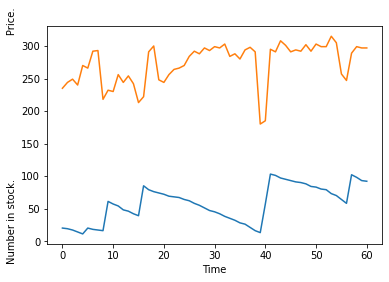

In [12]:
class Plot_prices(object):
  """Set up the plot for history of price and number in stock"""
  def __init__(self, ag,env):
      self.ag = ag
      self.env = env
      plt.ion()
      plt.xlabel("Time")
      plt.ylabel("Number in stock.                                              Price.")

  def plot_run(self):
      """plot history of price and instock"""
      num = len(env.stock_history)
      plt.plot(range(num),env.stock_history,label="In stock")
      plt.plot(range(num),env.price_history,label="Price")
      #plt.legend(loc="upper left")
      plt.draw()

pl = Plot_prices(ag,env)
#ag.go(90); 
pl.plot_run()